# Overview

In this notebook, a Neural Network model is constructed for tweet data with the aim of predicting tweets containing disaster news content or not. Then, the performance comparison with the model is done in the Disaster Tweets with Machine Learning.ipynb file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

C:\Users\user\miniconda3\envs\defiska\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

# Import Data

In [3]:
df = pd.read_csv('File CSV/data_clean.csv')
df.head()

,Unnamed: 0,id,text,target,Unnamed: 0.1,lat,lon,country
0,0,48,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,64,52.47891,-1.90592,GBR
1,1,50,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,69,7.18810,21.09375,CAF
2,2,52,Crying out for more! Set me ablaze,0,118,39.95222,-75.16218,USA
3,3,53,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,127,51.50642,-0.12721,GBR
4,4,54,@PhDSquares #mufc they've built so much hype a...,0,140,-25.74587,28.18763,ZAF


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    3800 non-null   int64  
 1   id            3800 non-null   int64  
 2   text          3800 non-null   object 
 3   target        3800 non-null   int64  
 4   Unnamed: 0.1  3800 non-null   int64  
 5   lat           3800 non-null   float64
 6   lon           3800 non-null   float64
 7   country       3800 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 237.6+ KB


# Data Preprocessing

### 1. Text Preprocessing

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from string import punctuation
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
# Stopwords Selection

tfidf = TfidfVectorizer(tokenizer=word_tokenize,min_df=4)
tfidf_matrix = tfidf.fit_transform(df['text']) 

In [7]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

In [8]:
df_tfidf_top50 = pd.DataFrame(df_tfidf.sum(axis=0).sort_values(ascending=False).head(50))

In [9]:
not_alnum = [x for x in df_tfidf.columns if x.isalnum()==False]

In [10]:
[i for i in df_tfidf_top50.index if i not in stopwords.words("english") + not_alnum]

['http', 'https', 'like', 'new', 'via']

In [11]:
added_sw = ['co','û_','amp',"'d", "'ll", "'re", "'s", "'ve",'``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would',
            'like','new','via','got', 'na', 'ta', 'wan', '05', '1', 'calif', 'dr', 'f', 'ft', 'ok', 'p.m', 'r', 'st', 'vs', 'wash', 'z',
           '10', '2', '2-u.s', '3', 'aug', 'corp', 'd.c', 'l.a', 'u.n', 'va','u.s']

In [12]:
sw_eng = stopwords.words("english") + list(punctuation) + not_alnum + added_sw

### 2. Text Encoding 

In [13]:
tfidf_encode = TfidfVectorizer(tokenizer=word_tokenize,min_df=4)

In [14]:
X = df.text
y = df.target.values

In [15]:
X = tfidf_encode.fit_transform(X)

### 3. Dataset Splitting 

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
X_train = X_train.todense()
X_test = X_test.todense()
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2660, 2107), (1140, 2107), (2660,), (1140,))

### 4. Dataset and Dataloader 

In [18]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [19]:
from torch.utils.data import DataLoader, TensorDataset

In [20]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set,batch_size=64,shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set,batch_size=64)

# Training

### 1. Training Preparation 

In [21]:
X_train.shape

torch.Size([2660, 2107])

In [22]:
model = nn.Sequential(
    nn.Linear(2107,4),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(4,2),
    nn.Tanh(),

    nn.Linear(2,2),
    nn.LogSoftmax(1),
).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [23]:
def loop_fn(mode,dataset,dataloader,model,criterion,optimizer,device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

### 2. Training Process 

In [24]:
epochs = 130
train_cost, test_cost = [], []
train_acc, test_acc = [], []
for i in range(epochs):
    cost, acc = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad():
        cost, acc = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_acc.append(acc)
        
    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f} | "
         f"train_acc: {train_acc[-1]:.4f} | test_acc: {test_acc[-1]:.4f}", end=" ")

Epoch: 130/130 | train_cost: 0.4567 | test_cost: 0.5138 | train_acc: 0.8195 | test_acc: 0.7675     

### 3. Cost History 

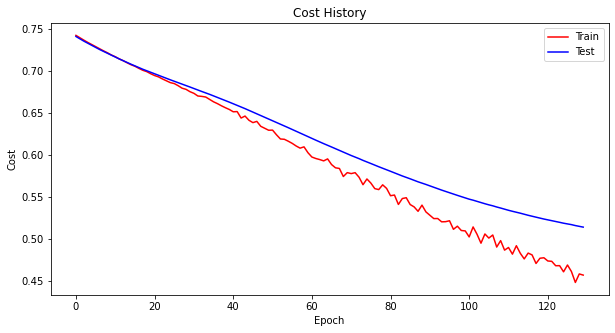

In [25]:
plt.subplots(figsize=(10,5))
plt.plot(train_cost,'-r',label='Train')
plt.plot(test_cost,'-b',label='Test')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost History')
plt.legend()

# Evaluation

In [26]:
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve

In [27]:
with torch.no_grad():
    model.eval()
    output = model(X_test)

In [28]:
y_pred = output.argmax(1)

In [29]:
# Classification Report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       624
           1       0.78      0.67      0.72       516

    accuracy                           0.77      1140
   macro avg       0.77      0.76      0.76      1140
weighted avg       0.77      0.77      0.77      1140



In [30]:
# ROC-AUC Score

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score is",roc_auc)

ROC-AUC score is 0.7591495229576624
